# Salt2 Fit Results

This notebook inspects the distribution and correlation of Salt2 parameters fit to the SDSS SN sample.

#### Table of Contents:
1. <a href='#loading_data'>Loading the Data</a>: Read in data and drop bad fits.
1. <a href='#fit_results'>Investigating Fit Results</a>: Plots of various fit parameters.
1. <a href='#with_class'>Trends with Classification</a>: Plots of various fit parameters color coded by classification.


In [3]:
import warnings
from multiprocessing.pool import Pool
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sncosmo
from astropy.table import Table
from corner import corner
from matplotlib.colors import LinearSegmentedColormap
from scipy import stats
from sndata.sdss import sako18
from tqdm.notebook import tqdm


sako18.download_module_data()
results_dir = Path('../results/').resolve()
fig_dir = Path('./notebook_figs/salt2_fits')
fig_dir.mkdir(exist_ok=True, parents=True)


## Loading the Data <a id='loading_data'></a>

We load fit results from Salt 2.4 and join the results with the `master` table from the SDSS data release. Since it is not available as part of the fit results, we calculate the B - V color at $t_{max}$ for each of the fitted SNe.

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    salt2_fits = Table.read(results_dir / 'sdss_salt2_fits.ecsv').to_pandas(index='obj_id')
    sako_master = sako18.load_table('master').to_pandas(index='CID')
    salt2_fits = salt2_fits.join(sako_master)


In [5]:
salt2 = sncosmo.Model('salt2')
   
color = []
for idx, row in salt2_fits.iterrows():
    salt2.update({p: row[p] for p in salt2.param_names})
    
    t0 = salt2.parameters[salt2.param_names.index('t0')]
    z = salt2.parameters[salt2.param_names.index('z')]
    if np.isnan(t0) or z > .8:  # Outside model range
        color.append(np.nan)
        continue
        
    color.append(salt2.color('standard::B', 'standard::V', 'AB', t0))
    
salt2_fits['max_color'] = color
salt2_fits


/home/djperrefort/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/sncosmo/models.py:186: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)


,band,source,pre_max,post_max,vparams,z,t0,x0,x1,c,...,logMasshiPEGASE,logSFRPEGASE,logSFRloPEGASE,logSFRhiPEGASE,agePEGASE,ageloPEGASE,agehiPEGASE,minchi2PEGASE,Notes,max_color
obj_id,,,,,,,,,,,,,,,,,,,,,
1000,all,salt2,0.0,110.0,"t0,x0,x1,c",0.128293,2.453612e+06,0.000135,-1.784709,-0.017655,...,10.33,-99.00,-99.00,-0.47,3.18,3.03,4.02,3.06,NaN,0.165708
10028,all,salt2,90.0,15.0,"t0,x0,x1,c",0.064256,2.453694e+06,0.000799,-0.979333,0.028178,...,10.46,0.05,-0.08,0.05,2.41,2.41,2.59,19.23,NaN,-0.003400
10036,all,salt2,90.0,15.0,"z,t0,x0,x1,c",0.473146,2.453690e+06,0.000017,-0.013916,-0.096757,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.137728
10037,all,salt2,75.0,30.0,"t0,x0,x1,c",0.252461,2.453688e+06,0.000035,-0.830579,0.057148,...,10.82,-0.92,-99.00,-0.91,4.02,3.03,4.52,2.07,NaN,0.804253
10045,all,salt2,79.0,20.0,"t0,x0,x1,c",0.114762,2.453695e+06,0.000064,1.095815,0.347700,...,9.31,0.13,-0.17,0.42,0.19,0.09,0.58,4.25,NaN,0.433855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9672,all,salt2,40.0,74.0,"t0,x0,x1,c",0.188192,2.453645e+06,0.000009,5.000000,0.500000,...,11.32,-99.00,-99.00,-99.00,5.04,3.48,10.10,27.80,NaN,0.812359
9739,all,salt2,70.0,34.0,"t0,x0,x1,c",0.118202,2.453687e+06,0.000032,1.670366,0.482830,...,10.84,1.11,1.09,1.11,1.02,1.02,1.09,1.49,NaN,0.570304


In [6]:
good_fits = salt2_fits[['z', 'c', 'x1', 'x0', 't0', 'chisq', 'ndof', 'b_max', 'delta_15', 'max_color']].dropna()


Next we determine the photometric classification of each object.

In [7]:
# Read in the classification coordinates
coord_path = results_dir / 'collective_fits/with_ext/sdss_sako18_simple_fit_class.ecsv'
class_coords = Table.read(coord_path).to_pandas(index='obj_id')
class_coords.head()


,x,y
obj_id,,
10028,-30.734722,-61.826105
10036,0.266537,0.091667
10037,-1.158080,-0.182717
1008,-3.745179,-0.493055
10096,-5.129167,0.857690


In [8]:
sdss_master = sako18.load_table('master')
sako_classification = pd.DataFrame({
    'obj_id': sdss_master['CID'],
    'spec_class': sdss_master['Classification']
})
sako_classification.set_index('obj_id', inplace=True)

non_sne = sako_classification[sako_classification['spec_class'].isin(('Variable', 'AGN'))]


def passes_cut(obj_id):
    """Return if an object has data in >=2 bands and at
    least one point before and after max.
    
    Return is false for all AGN and Variables
    
    Args:
        obj_id (str): The object Id
        
    Returns:
        A boolean
    """

    if obj_id in non_sne.index:
        return False

    obj_data = sako18.get_data_for_id(obj_id).to_pandas()
    obj_data = obj_data[obj_data.flux / obj_data.fluxerr >= 5]
    num_bands = len(obj_data.band.unique())
    salt2_fits = Table.read(results_dir / 'sdss_salt2_fits.ecsv').to_pandas(index='obj_id')

    try:
        salt_fit = salt2_fits.loc[obj_id]
        return all(
            (salt_fit.pre_max, salt_fit.post_max, (num_bands >= 2))
        )

    except KeyError:
        return False


def get_good_ids(cache_file=results_dir / 'good_ids.npy'):
    """Get SDSS object Ids for targets passing observation cuts
    
    Results are cached to file for performance.
    
    Args:
        cache_file (str): Path to cache return to
        
    Returns:
        An array of object Ids
    """

    if Path(cache_file).exists():
        return np.load(cache_file)

    sako_obj_ids = sako18.get_available_ids()
    with Pool() as p:
        is_good_id = list(tqdm(p.imap(passes_cut, sako_obj_ids), total=len(sako_obj_ids)))

    good_obj_ids = np.array(sako_obj_ids)[is_good_id].tolist()
    np.save(cache_file, good_obj_ids)
    return good_obj_ids


In [9]:
# Select the Id's of peculiar objects based on the desired cutoff
x_cutoff = 3
y_cutoff = 0

pec_ids = class_coords[(class_coords.x < - x_cutoff) & (class_coords.y > y_cutoff)].index
sn91bg_ids = class_coords[(class_coords.x >= x_cutoff) & (class_coords.y >= y_cutoff)].index
sdss_ia_ids = sako_master[sako_master.Classification.isin(['SNIa', 'SNIa?'])].index


In [10]:
pec_ids = list(pec_ids[pec_ids.isin(get_good_ids())])
sn91bg_ids = list(sn91bg_ids[sn91bg_ids.isin(get_good_ids())])
sdss_ia_ids = list(sdss_ia_ids[sdss_ia_ids.isin(get_good_ids())])


## Investigating Fit Results <a id='fit_results'></a>

We look at trends within the fitted model parameters.


In [11]:
def scatter_plot(x, y, c=None, contour=False, class_by=None, x_cutoff=0, y_cutoff=0):
    """Create a scatter plot with bordering histograms
    
    Args:
        x    (ndarray): x values to plot
        y    (ndarray): y values to plot
        c    (ndarray): Optional values for a colorbar
        contour (bool): Whether to plot contours
        class_by   (str): Classify by "collective" or "band" fits
        x_cutoff (float): The x cutoff for bg classifications
        y_cutoff (float): The y cutoff for bg classifications
        
    Returns:
        A seaborn figure
        A matplotlib axis for the color bar, if c is provided
    """

    joint_plot = sns.jointplot(x, y, height=8)
    scatter_ax = joint_plot.ax_joint
    
    if c is not None:
        scatter_ax.cla()
        basic_cols = ['blue', 'lightgrey', 'red']
        cmap = LinearSegmentedColormap.from_list('mycmap', basic_cols)
        s = scatter_ax.scatter(x, y, c=c, cmap=cmap, s=12)

        ax_pos = scatter_ax.get_position()
        ax_pos.y0 -= .2
        ax_pos.y1 = ax_pos.y0 + .05
        cbar_ax = plt.gcf().add_axes(ax_pos)
        plt.colorbar(s, cax=cbar_ax, orientation='horizontal')
        return joint_plot, cbar_ax 
    
    elif class_by is not None:
        x_coord = class_coords['x_' + class_by]
        y_coord = class_coords['y_' + class_by]
        sn91bg = class_coords[(x_coord > x_cutoff) & (y_coord > y_cutoff)].index
        normal = class_coords[(x_coord < x_cutoff) & (y_coord < y_cutoff)].index
        pec = class_coords[(x_coord < x_cutoff) & (y_coord > y_cutoff)].index

        scatter_ax.cla()
        scatter_ax.scatter(x.reindex(normal), y.reindex(normal), 
                          color=sns.color_palette('Paired')[0],
                          #color='C0',
                          s=12, label='Q3')
        
        scatter_ax.scatter(x.reindex(sn91bg), y.reindex(sn91bg), color='C3', marker='^', label='Q1')
        scatter_ax.scatter(x.reindex(pec), y.reindex(pec), color='C1', marker='s', label='Q2') 
        scatter_ax.legend()
        
    if contour:
        sns.kdeplot(x, y, ax=scatter_ax, color='black', alpha=.8)
        
    return joint_plot


Text(45.125, 0.5, 'Stretch (x$_1$)')

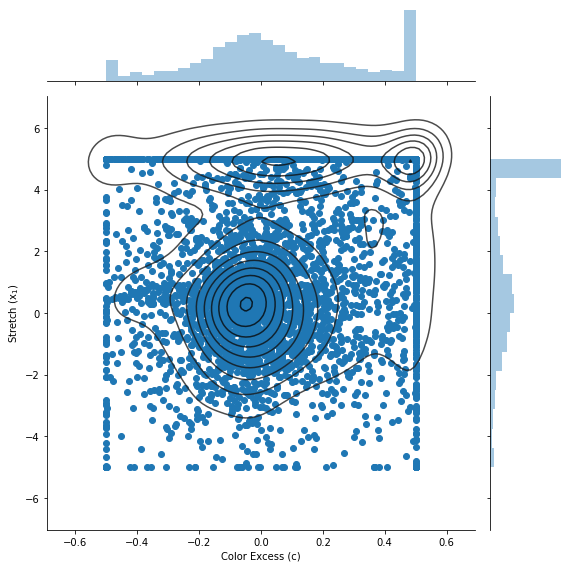

In [12]:
stretch_color = scatter_plot(good_fits.c, good_fits.x1, contour=True)
stretch_color.ax_joint.set_xlabel('Color Excess (c)')
stretch_color.ax_joint.set_ylabel(r'Stretch (x$_1$)')


(-25, -10)

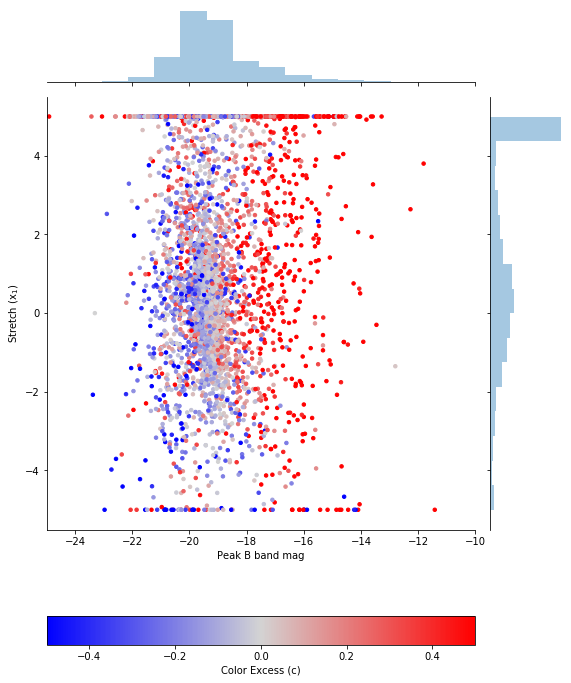

In [13]:
stretch_bmax, cbar = scatter_plot(good_fits.b_max, good_fits.x1, good_fits.c)
stretch_bmax.ax_joint.set_xlabel('Peak B band mag')
stretch_bmax.ax_joint.set_ylabel(r'Stretch (x$_1$)')
cbar.set_xlabel('Color Excess (c)')
stretch_bmax.ax_joint.set_xlim(-25, -10)


(-25, -10)

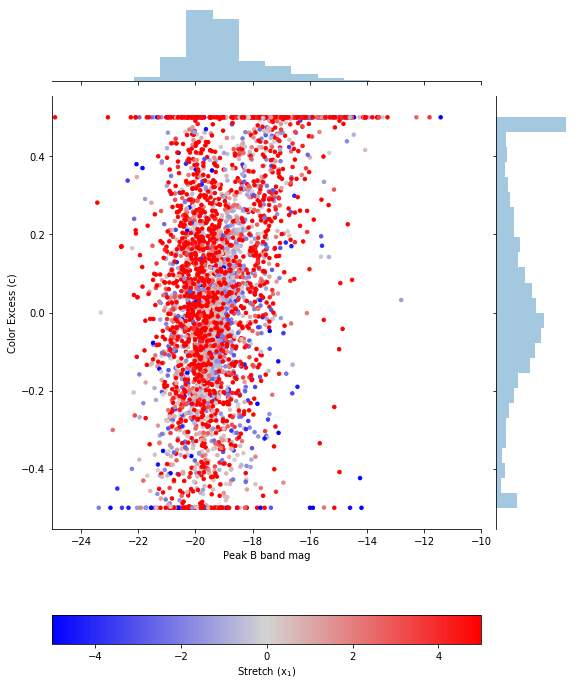

In [14]:
color_bmax, cbar = scatter_plot(good_fits.b_max, good_fits.c, good_fits.x1)
color_bmax.ax_joint.set_xlabel('Peak B band mag')
color_bmax.ax_joint.set_ylabel(r'Color Excess (c)')
cbar.set_xlabel(r'Stretch (x$_1$)')
color_bmax.ax_joint.set_xlim(-25, -10)

Text(0.5, 0, 'Color Excess (c)')

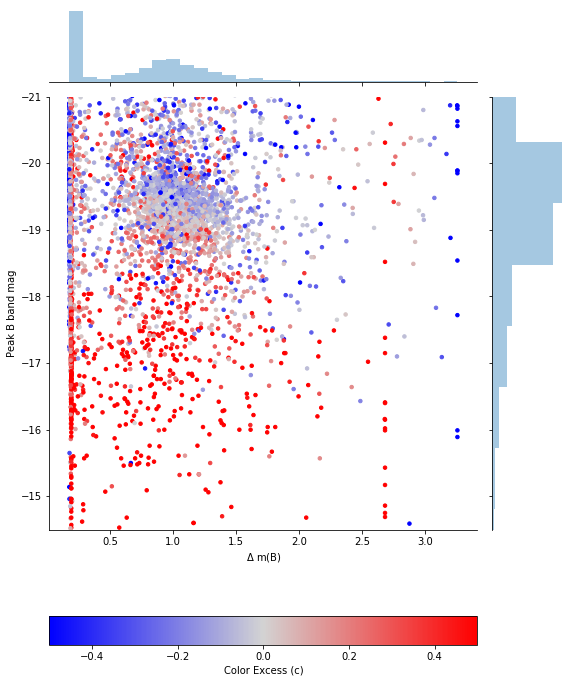

In [15]:
delta15_bmax, cbar = scatter_plot(good_fits.delta_15, good_fits.b_max, good_fits.c)
delta15_bmax.ax_joint.set_xlabel(r'$\Delta$ m(B)')
delta15_bmax.ax_joint.set_ylabel('Peak B band mag')
delta15_bmax.ax_joint.set_ylim(-21, -14.5)
delta15_bmax.ax_joint.invert_yaxis()
cbar.set_xlabel('Color Excess (c)')


## Trends with Classification <a id='with_class'></a>

We create a corner plot with subplots similar to the previous section, but include classification data.

In [16]:
def density_estimation(m1, m2):
    xmin = ymin = np.min([m1, m2])
    xmax = ymax = np.max([m1, m2])
    
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]                                                     
    positions = np.vstack([X.ravel(), Y.ravel()])                                                       
    values = np.vstack([m1, m2])                                                                        
    kernel = stats.gaussian_kde(values)                                                                 
    Z = np.reshape(kernel(positions).T, X.shape)
    return X, Y, Z

def plot_corner(data, columns, labels, ranges, x_cutoff=0, y_cutoff=0):
    """Create a corner plot of fit parameters
    
    Args:
        sn91bg (list[str]): List of object IDs for 91bg-like objects
        data (Dataframe): The data to use when plotting
        columns   (list): The names of the columns to plot
        ranges    (list): Plottin limits for each column
        class_by   (str): Classify by "collective" or "band" fits
        x_cutoff (float): The x cutoff for bg classifications
        y_cutoff (float): The y cutoff for bg classifications
        
    Returns:
        A matplotlib figure
    """
    
    # Create initial plot
    corner_data = np.array(data[columns].reindex(sdss_ia_ids).dropna())
    fig = corner(
        corner_data, 
        labels=labels, 
        figsize=(7, 7), 
        range=ranges,
        hist_kwargs={'histtype': 'bar', 'color': 'grey'}, 
        label_kwargs={'fontsize': 14},
        plot_contours=False, 
        show_titles=True,
        plot_density=True,
        color='grey'
    )

    # Isolate plots in lower triangle of figure
    num_cols = len(columns)
    axes = np.reshape(fig.axes, (num_cols, num_cols))
    skip_countors = [(4, 0)]
    
    # Replace scatter plots withcustom plots
    for i, j in zip(*np.tril_indices(num_cols, -1)):
        axis = axes[i, j]        
        x = data[columns[j]]
        y = data[columns[i]]
        
        label_prefix = '' if (i==1 and j==0) else '_'
        # axis.scatter(
        #     x.reindex(normal), 
        #     y.reindex(normal), 
        #     s=1, 
        #     color='grey',
        #     alpha=.7,
        #     label=label_prefix + f'Quadrant 3 (x < {x_cutoff}, y < {y_cutoff})')
        
        if (i, j) not in skip_countors:
            X, Y, Z = density_estimation(
                x.loc[x.index.intersection(sdss_ia_ids)], 
                y.loc[y.index.intersection(sdss_ia_ids)])
            
            axis.contour(X, Y, Z, colors='k', alpha=.6)
        
        axis.scatter(
            x.reindex(pec_ids), 
            y.reindex(pec_ids),
            s=15, 
            marker='^', 
            color='C0',
            label=label_prefix + f'Quadrant 2 (x < {x_cutoff}, y > {y_cutoff})',
            zorder=9,
            alpha=.5
        ) 
        
        axis.scatter(
            x.reindex(sn91bg_ids),
            y.reindex(sn91bg_ids),
            s=15, 
            marker='s',
            color='C1',
            label=label_prefix + f'Quadrant 1 (x > {x_cutoff}, y > {y_cutoff})',
            zorder=10,
            alpha=1
        )

    # Peak density lines on scatter plots
    diagonal_plots = axes[np.diag_indices(num_cols)]
    for col_name, axis in zip(columns, diagonal_plots):
        col_data = data[col_name].reindex(sdss_ia_ids).dropna()
        mean = col_data.mean()
        std = col_data.std()

        axis.axvline(mean, color='k', alpha=.8, linestyle='--')
        axis.axvline(mean + std, color='k', alpha=.8, linestyle=':')
        axis.axvline(mean - std, color='k', alpha=.8, linestyle=':')
        axis.yaxis.tick_right()
        
        ymax = 175
        ticks = np.arange(0, ymax + 1, 25)
        axis.set_yticks(ticks)
        
        labels = [int(t) for t in ticks]
        labels[0] = ''
        axis.set_yticklabels(labels)
        # axis.yaxis.set_minor_locator(MultipleLocator(5))
        # axis.set_title(fr'{mean: .2f} $\pm$ {std: .2f}')

    plt.subplots_adjust(wspace=.1, hspace=.1)
    return fig, axes


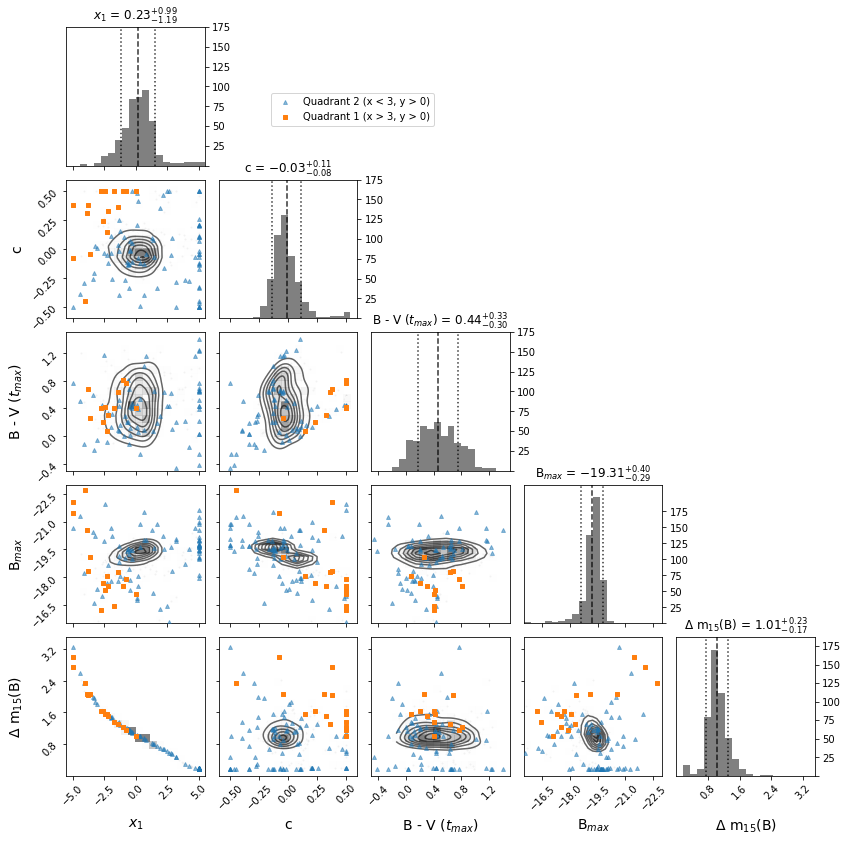

In [19]:
fig, axes = plot_corner(
    data=good_fits.dropna(),
    columns=['x1', 'c', 'max_color', 'b_max', 'delta_15'],
    labels=[r'$x_1$', 'c', r'B - V ($t_{max}$)', r'B$_{max}$', r'$\Delta$ m$_{15}$(B)'],
    ranges=((-5.5, 5.5), (-.6, .6), (-.5, 1.5), (-15.5, -23), (0, 3.5)),
    x_cutoff=x_cutoff,
    y_cutoff=y_cutoff
)

# axes[-1][-2].axvline(-18.5, color='k', linestyle='-.', label=r'B$_{max}=-18.5$')
# for axis in axes[3, :-2]:
#     axis.axhline(-18.5, color='k', linestyle='-.')

# axes[1][0].axhline(0, color='k', linestyle='-.')
# for axis in axes[2:, 1]:
#     axis.axvline(0, color='k', linestyle='-.')

fig.legend(loc=(.32, .85))
plt.savefig(fig_dir / 'params_corner_plot.pdf')


In [18]:
print('Average 91bg Delta 15:', salt2_fits.loc[sn91bg_ids].delta_15.mean())
print('Average Ia Delta 15:', salt2_fits.loc[sdss_ia_ids].delta_15.mean())
print('Average 91bg Peak Color:', salt2_fits.loc[sn91bg_ids].max_color.mean())


Average 91bg Delta 15: 1.6709411764705882
Average Ia Delta 15: 1.028457805907173
Average 91bg Peak Color: 1.0583168197029187
